<center> <h1>Proje - Derin öğrenme</h1></center>
<center> <h5> Fatma RIDAOUI </h5> </center>
<center><h6> 91220001225 </h6> </center>
    


In [1]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import ResNet50
from PIL import ImageFile, Image
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow import keras
from keras_tuner.tuners import RandomSearch
import keras_tuner as kt
from keras_tuner import HyperParameters
import sys
import random
from PIL import Image as im

In [2]:
if tf.test.gpu_device_name():
    print('GPU found')
else:
    print("No GPU found")
print(tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


GPU found
2.10.1
Num GPUs Available:  1


In [3]:
list_train= os.listdir(r"C:\Users\zouhair\Desktop\Fatma's\OneDrive - Ege Üniversitesi\Ege_Dr_D2\Deep Learning\proje1\images\Train")

In [4]:
classes ={}
df_dataset= []
for each in list_train:
    className = each.split('(')[0].replace(" ","")
    df_dataset.append([each, className])
    if className not in classes:
        classes[className] = 0
    else:
        classes[className] = classes[className] +1
    # if len(classes)==4 and list(classes.values())[-1] ==40:
    #     break

In [5]:
classes

{'100': 40,
 'among': 40,
 'angry': 40,
 'ankh': 40,
 'aroura': 40,
 'at': 40,
 'badthinking': 40,
 'bandage': 40,
 'bee': 40,
 'belongs': 40,
 'birth': 40,
 'boardgame': 40,
 'book': 40,
 'boy': 39,
 'branch': 40,
 'bread': 40,
 'brewer': 40,
 'builder': 40,
 'bury': 40,
 'canal': 40,
 'clothonpole': 40,
 'cobra': 40,
 'composite_bow': 40,
 'cooked': 40,
 'corpse': 40,
 'dessert': 40,
 'divide': 40,
 'duck': 40,
 'elephant': 40,
 'enclosedmound': 40,
 'eye': 40,
 'fabric': 40,
 'face': 40,
 'falcon': 40,
 'fingre': 40,
 'fish': 40,
 'flail': 40,
 'folded': 40,
 'foot': 40,
 'galena': 40,
 'giraffe': 39,
 'he': 40,
 'Her': 40,
 'hit': 40,
 'horn': 40,
 'king': 40,
 'leg': 39,
 'lengthofahumanarm': 40,
 'lifespirit': 40,
 'limits': 40,
 'lion': 40,
 'lizard': 40,
 'loafofbread': 40,
 'loaf': 40,
 'man': 40,
 'mascot': 40,
 'meet': 40,
 'mother': 40,
 'mouth': 40,
 'musicalinstrument': 40,
 'nilefish': 40,
 'not': 40,
 'now': 40,
 'nurse': 40,
 'nursing': 40,
 'occur': 40,
 'one': 40,
 '

In [4]:
list_test = os.listdir(r"C:\Users\zouhair\Desktop\Fatma's\OneDrive - Ege Üniversitesi\Ege_Dr_D2\Deep Learning\proje1\images\Test")

In [7]:
test_classes ={}
df_dataset_test = []
i=0
for each in list_test:
    className = each.split('(')[0].replace(" ","")
    df_dataset_test.append([each, className])
    
    if className not in test_classes:
        i=i+1
        test_classes[className] = 0
        
    else:
        test_classes[className] = test_classes[className] +1
      


In [8]:
test_classes

{'100': 10,
 'among': 10,
 'angry': 10,
 'ankh': 10,
 'aroura': 10,
 'at': 10,
 'badthinking': 10,
 'bandage': 10,
 'bee': 10,
 'belongs': 10,
 'birth': 10,
 'boardgame': 10,
 'book': 10,
 'boy': 10,
 'branch': 10,
 'bread': 10,
 'brewer': 10,
 'builder': 10,
 'bury': 10,
 'canal': 10,
 'clothonpole': 10,
 'cobra': 10,
 'composite_bow': 10,
 'cooked': 10,
 'corpse': 10,
 'dessert': 10,
 'divide': 10,
 'duck': 10,
 'elephant': 10,
 'enclosedmound': 10,
 'eye': 10,
 'fabric': 10,
 'face': 10,
 'falcon': 10,
 'fingre': 10,
 'fish': 10,
 'flail': 10,
 'folded': 10,
 'foot': 10,
 'galena': 10,
 'giraffe': 9,
 'he': 10,
 'Her': 9,
 'hit': 10,
 'horn': 10,
 'king': 10,
 'leg': 10,
 'lengthofahumanarm': 10,
 'lifespirit': 10,
 'limits': 10,
 'lion': 10,
 'lizard': 10,
 'loafofbread': 10,
 'loaf': 10,
 'man': 10,
 'mascot': 10,
 'meet': 9,
 'mother': 10,
 'mouth': 10,
 'musicalinstrument': 9,
 'nilefish': 10,
 'not': 10,
 'now': 10,
 'nurse': 10,
 'nursing': 10,
 'occur': 9,
 'one': 10,
 'owl':

In [9]:
random.shuffle(df_dataset)
df = pd.DataFrame(df_dataset, columns=['file_name', 'class'])

In [10]:
random.shuffle(df_dataset_test)
test_df = pd.DataFrame(df_dataset_test, columns=['file_name', 'class'])

In [11]:
image_size = (224,224)
batch_size= 16
input_shape=(224, 224, 3)
num_classes = len(classes) # 95

In [12]:
num_classes

95

In [13]:
base_model = ResNet50(include_top=False, weights='imagenet', input_shape=input_shape)

for layer in base_model.layers[:-26]:
    layer.trainable = False
for layer in base_model.layers[-26:]:
    layer.trainable = True

x = base_model.output
x = Flatten()(base_model.output)
x = Dense(100, activation='relu')(x)
predictions = Dense(num_classes, activation = 'softmax')(x)

# Define the hyperparameters to tune
#learning_rate = hp.Float('learning_rate', min_value=1e-3, max_value=1e-1, sampling='log')

optimizer = tf.keras.optimizers.Adam(learning_rate= 0.001)
# Build and compile the model
model = keras.models.Model(inputs=base_model.input, outputs=predictions)
model.compile( optimizer, loss='categorical_crossentropy', metrics=['accuracy'])


In [14]:
"""tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=3,
    directory='tuner_dir',
    project_name='resnet_model')"""


"tuner = RandomSearch(\n    build_model,\n    objective='val_accuracy',\n    max_trials=10,\n    executions_per_trial=3,\n    directory='tuner_dir',\n    project_name='resnet_model')"

In [15]:
path = "C:/Users/zouhair/Desktop/Fatma's/OneDrive - Ege Üniversitesi/Ege_Dr_D2/Deep Learning/proje1/images/Train"
test_path = "C:/Users/zouhair/Desktop/Fatma's/OneDrive - Ege Üniversitesi/Ege_Dr_D2/Deep Learning/proje1/images/Test"

datagen = ImageDataGenerator( rescale= 1./255, validation_split=0.2)

train_gen = datagen.flow_from_dataframe(dataframe=df, 
                                        directory= path,
                                        x_col= 'file_name',
                                        y_col= 'class',
                                        class_mode= "categorical",
                                        color_mode= 'rgb',
                                        subset= 'training',
                                        target_size= image_size,
                                        batch_size=batch_size )

val_gen = datagen.flow_from_dataframe(dataframe=df, 
                                        directory= path,
                                        x_col= 'file_name',
                                        y_col= 'class',
                                        class_mode= "categorical",
                                        color_mode= 'rgb',
                                        subset= 'validation',
                                        target_size= image_size,
                                        batch_size=batch_size )

test_gen = datagen.flow_from_dataframe( dataframe= test_df, 
                                        directory= test_path,
                                        x_col= 'file_name',
                                        y_col= 'class',
                                        subset= None,
                                        class_mode= "categorical",
                                        color_mode= 'rgb',
                                        target_size= image_size,
                                        batch_size= batch_size)

Found 3114 validated image filenames belonging to 95 classes.
Found 778 validated image filenames belonging to 95 classes.
Found 1039 validated image filenames belonging to 95 classes.


In [16]:
# Train the model
history=model.fit(train_gen, epochs=10, validation_data=val_gen, verbose=1)

Epoch 1/10
195/195 [==============================] - 56s 219ms/step - loss: 4.9773 - accuracy: 0.0064 - val_loss: 4.5556 - val_accuracy: 0.0064
Epoch 2/10
195/195 [==============================] - 40s 203ms/step - loss: 4.5543 - accuracy: 0.0100 - val_loss: 4.5572 - val_accuracy: 0.0051
Epoch 3/10
195/195 [==============================] - 41s 210ms/step - loss: 4.5540 - accuracy: 0.0103 - val_loss: 4.5589 - val_accuracy: 0.0039
Epoch 4/10
195/195 [==============================] - 41s 208ms/step - loss: 4.5538 - accuracy: 0.0077 - val_loss: 4.5603 - val_accuracy: 0.0039
Epoch 5/10
195/195 [==============================] - 41s 208ms/step - loss: 4.5535 - accuracy: 0.0087 - val_loss: 4.5617 - val_accuracy: 0.0039
Epoch 6/10
195/195 [==============================] - 40s 205ms/step - loss: 4.5533 - accuracy: 0.0122 - val_loss: 4.5629 - val_accuracy: 0.0039
Epoch 7/10
195/195 [==============================] - 40s 206ms/step - loss: 4.5531 - accuracy: 0.0122 - val_loss: 4.5640 - val_ac

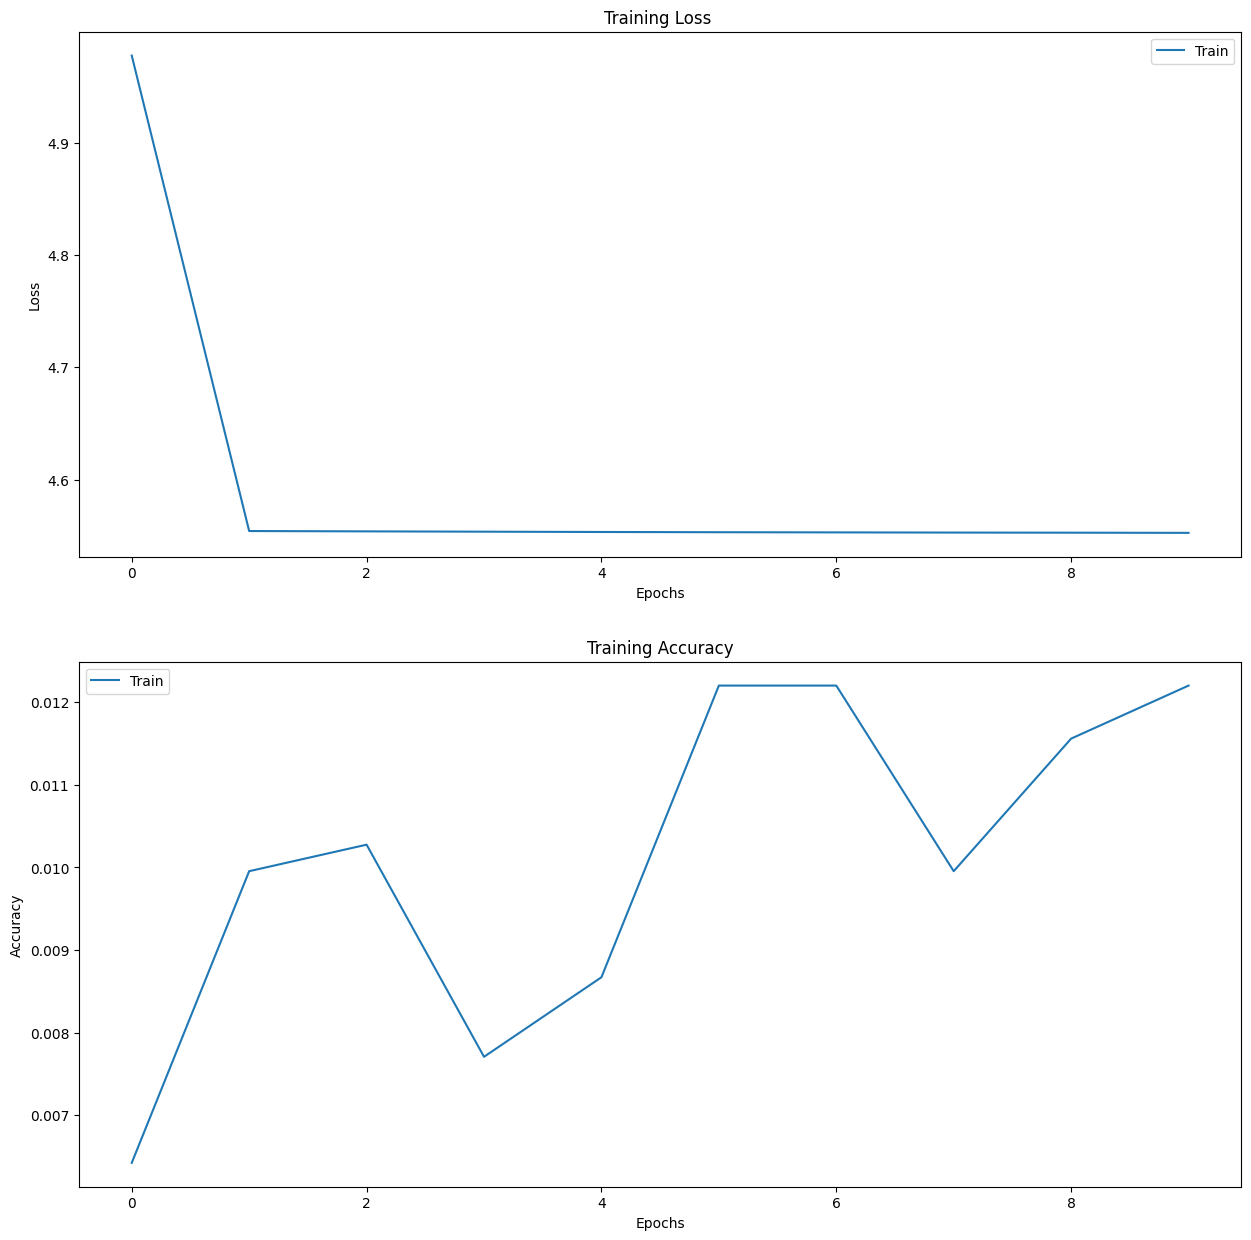

In [17]:
fig, axs = plt.subplots(2, 1, figsize=(15,15))

axs[0].plot(history.history['loss'])
axs[0].title.set_text('Training Loss ')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend(['Train'])

axs[1].plot(history.history['accuracy'])
axs[1].title.set_text('Training Accuracy')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend(['Train'])

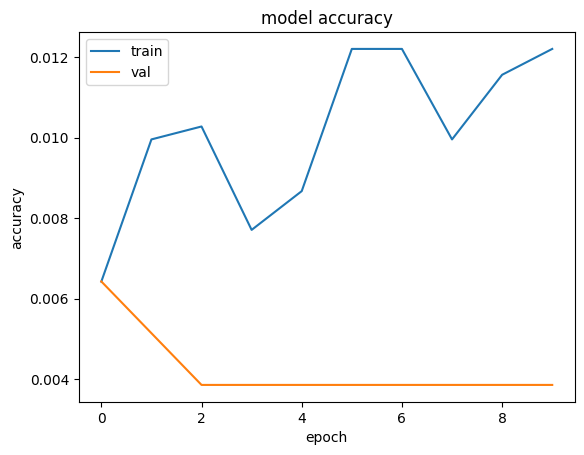

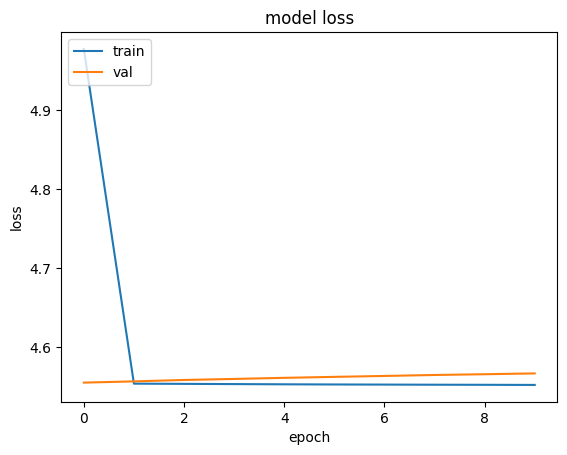

In [18]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [20]:
loss, acc = model.evaluate(test_gen, verbose=2)
print("Restored model, accuracy: {:5.2f}%".format(100 * acc))

65/65 - 10s - loss: 4.5548 - accuracy: 0.0106 - 10s/epoch - 157ms/step
Restored model, accuracy:  1.06%


In [26]:
model.save(r"C:\Users\zouhair\Desktop\Fatma's\OneDrive - Ege Üniversitesi\Ege_Dr_D2\Deep Learning\proje1\mymodel1.h5")

In [28]:
print("Evaluate on test data")
results = model.evaluate(test_gen, batch_size=16)
print("test loss, test acc:", results)

Evaluate on test data
65/65 [==============================] - 9s 137ms/step - loss: 4.5548 - accuracy: 0.0106
test loss, test acc: [4.554782390594482, 0.010587102733552456]


# Accuracy çok düşük. Sınıf sayısını 4 ile deneyip sonuçları inceleyebiliriz

In [38]:
num_classes =4

In [81]:
num_classes =4
classes ={}
df_dataset= []
for each in list_train:
    className = each.split('(')[0].replace(" ","")
    df_dataset.append([each, className])
    if className not in classes:
        classes[className] = 0
    else:
        classes[className] = classes[className] +1
    if len(classes)==4 and list(classes.values())[-1] ==40:
        break

In [82]:
test_classes ={}
df_dataset_test = []

for each in list_test:
    className = each.split('(')[0].replace(" ","")
    df_dataset_test.append([each, className])
  
    if className not in test_classes:
        test_classes[className] = 0    
    else:
        test_classes[className] = test_classes[className] +1
    if len(df_dataset_test)==40 or len(test_classes)==4 and list(test_classes.values())[-1] ==10:
        print(len(test_classes),len(df_dataset_test))
        break  

4 40


In [83]:
test_classes, classes

({'100': 10, 'among': 10, 'angry': 10, 'ankh': 6},
 {'100': 40, 'among': 40, 'angry': 40, 'ankh': 40})

In [84]:
random.shuffle(df_dataset)
df_dataset = pd.DataFrame(df_dataset, columns=['file_name', 'class'])
random.shuffle(df_dataset_test)
df_dataset_test = pd.DataFrame(df_dataset_test , columns=['file_name', 'class'])

In [85]:
base_model = ResNet50(include_top=False, weights='imagenet', input_shape=input_shape)

for layer in base_model.layers[:-26]:
    layer.trainable = False
for layer in base_model.layers[-26:]:
    layer.trainable = True

x = base_model.output
x = Flatten()(base_model.output)
x = Dense(100, activation='relu')(x)
predictions = Dense(num_classes, activation = 'softmax')(x)

# Define the hyperparameters to tune
#learning_rate = hp.Float('learning_rate', min_value=1e-3, max_value=1e-1, sampling='log')

optimizer = tf.keras.optimizers.Adam(learning_rate= 0.001)
# Build and compile the model
model = keras.models.Model(inputs=base_model.input, outputs=predictions)
model.compile( optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [86]:
path = "C:/Users/zouhair/Desktop/Fatma's/OneDrive - Ege Üniversitesi/Ege_Dr_D2/Deep Learning/proje1/images/Train"
test_path = "C:/Users/zouhair/Desktop/Fatma's/OneDrive - Ege Üniversitesi/Ege_Dr_D2/Deep Learning/proje1/images/Test"

datagen = ImageDataGenerator( rescale= 1./255, validation_split=0.2)

train_gen = datagen.flow_from_dataframe(dataframe=df_dataset, 
                                        directory= path,
                                        x_col= 'file_name',
                                        y_col= 'class',
                                        class_mode= "categorical",
                                        color_mode= 'rgb',
                                        subset= 'training',
                                        target_size= image_size,
                                        batch_size=batch_size )

val_gen = datagen.flow_from_dataframe(dataframe=df_dataset, 
                                        directory= path,
                                        x_col= 'file_name',
                                        y_col= 'class',
                                        class_mode= "categorical",
                                        color_mode= 'rgb',
                                        subset= 'validation',
                                        target_size= image_size,
                                        batch_size=batch_size )

test_gen = datagen.flow_from_dataframe( dataframe= df_dataset_test, 
                                        directory= test_path,
                                        x_col= 'file_name',
                                        y_col= 'class',
                                        subset= None,
                                        class_mode= "categorical",
                                        color_mode= 'rgb',
                                        target_size= image_size,
                                        batch_size= batch_size)

Found 132 validated image filenames belonging to 4 classes.
Found 32 validated image filenames belonging to 4 classes.
Found 40 validated image filenames belonging to 4 classes.


In [87]:
# Train the model
history=model.fit(train_gen, epochs=10, validation_data=val_gen)

Epoch 1/10
9/9 [==============================] - 7s 341ms/step - loss: 20.9357 - accuracy: 0.2576 - val_loss: 20.3076 - val_accuracy: 0.1250
Epoch 2/10
9/9 [==============================] - 2s 170ms/step - loss: 4.1227 - accuracy: 0.1970 - val_loss: 43.0088 - val_accuracy: 0.1250
Epoch 3/10
9/9 [==============================] - 2s 169ms/step - loss: 2.1421 - accuracy: 0.2576 - val_loss: 48.7514 - val_accuracy: 0.3438
Epoch 4/10
9/9 [==============================] - 2s 174ms/step - loss: 1.7669 - accuracy: 0.2424 - val_loss: 38.7181 - val_accuracy: 0.1250
Epoch 5/10
9/9 [==============================] - 2s 170ms/step - loss: 1.5942 - accuracy: 0.2273 - val_loss: 32.6275 - val_accuracy: 0.1250
Epoch 6/10
9/9 [==============================] - 2s 170ms/step - loss: 1.3861 - accuracy: 0.2879 - val_loss: 27.4796 - val_accuracy: 0.1250
Epoch 7/10
9/9 [==============================] - 2s 169ms/step - loss: 1.3861 - accuracy: 0.2879 - val_loss: 22.2669 - val_accuracy: 0.1250
Epoch 8/10
9

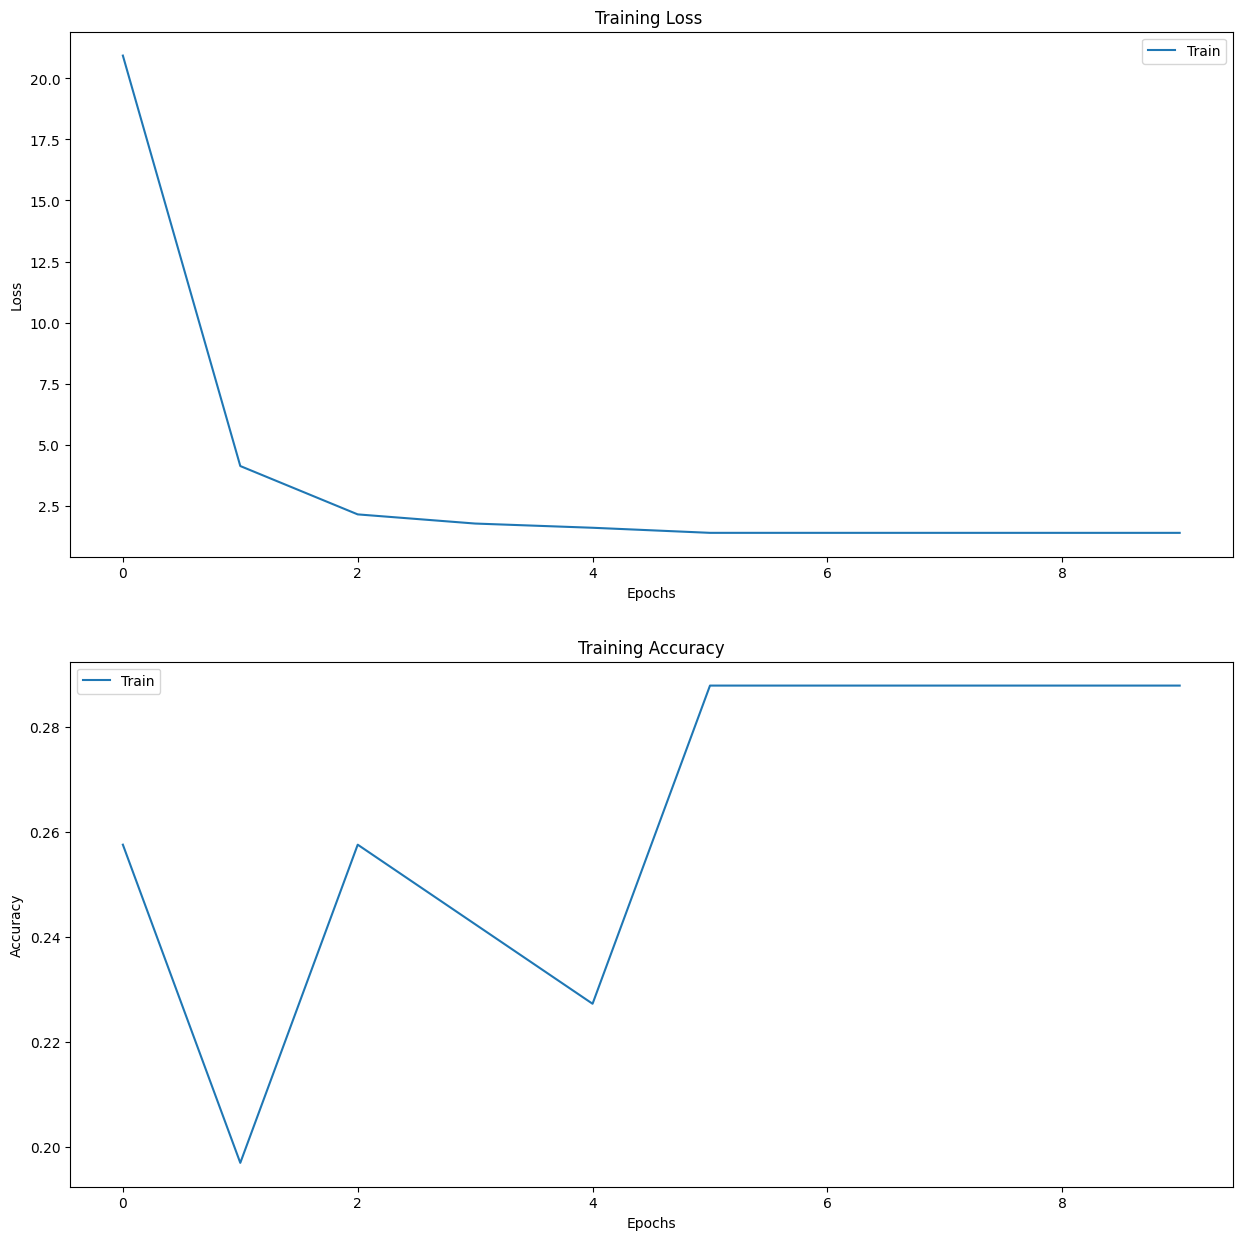

In [88]:
fig, axs = plt.subplots(2, 1, figsize=(15,15))

axs[0].plot(history.history['loss'])
axs[0].title.set_text('Training Loss ')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend(['Train'])

axs[1].plot(history.history['accuracy'])
axs[1].title.set_text('Training Accuracy')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend(['Train'])

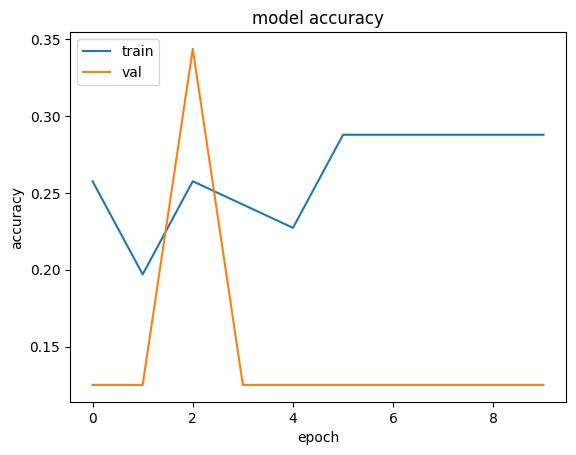

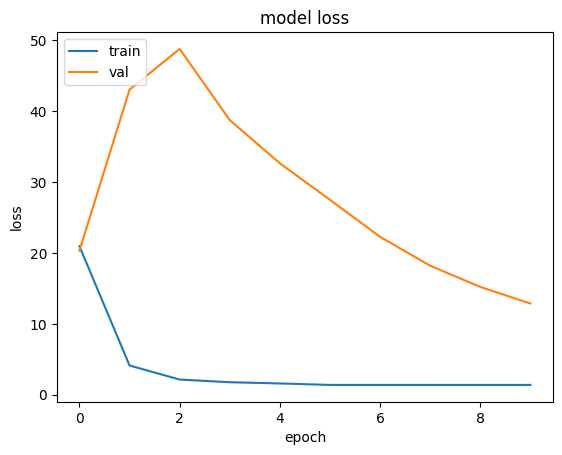

In [89]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Image size'ı artırmayı denesek ? 

In [ ]:
image_size = (512,512)
batch_size= 16
input_shape=(512, 512, 3)
num_classes = 4

In [120]:
base_model = ResNet50(include_top=False, weights='imagenet', input_shape=input_shape)

for layer in base_model.layers[:-26]:
    layer.trainable = False
for layer in base_model.layers[-26:]:
    layer.trainable = True

x = base_model.output
x = Flatten()(base_model.output)
x = Dense(100, activation='relu')(x)
predictions = Dense(num_classes, activation = 'softmax')(x)

# Define the hyperparameters to tune
#learning_rate = hp.Float('learning_rate', min_value=1e-3, max_value=1e-1, sampling='log')

optimizer = tf.keras.optimizers.Adam(learning_rate= 0.001)
# Build and compile the model
model = keras.models.Model(inputs=base_model.input, outputs=predictions)
model.compile( optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [121]:
path = "C:/Users/zouhair/Desktop/Fatma's/OneDrive - Ege Üniversitesi/Ege_Dr_D2/Deep Learning/proje1/images/Train"
test_path = "C:/Users/zouhair/Desktop/Fatma's/OneDrive - Ege Üniversitesi/Ege_Dr_D2/Deep Learning/proje1/images/Test"

datagen = ImageDataGenerator( rescale= 1./255, validation_split=0.2)

train_gen = datagen.flow_from_dataframe(dataframe=df_dataset, 
                                        directory= path,
                                        x_col= 'file_name',
                                        y_col= 'class',
                                        class_mode= "categorical",
                                        color_mode= 'rgb',
                                        subset= 'training',
                                        target_size= image_size,
                                        batch_size=batch_size )

val_gen = datagen.flow_from_dataframe(dataframe=df_dataset, 
                                        directory= path,
                                        x_col= 'file_name',
                                        y_col= 'class',
                                        class_mode= "categorical",
                                        color_mode= 'rgb',
                                        subset= 'validation',
                                        target_size= image_size,
                                        batch_size=batch_size )

test_gen = datagen.flow_from_dataframe( dataframe= df_dataset_test, 
                                        directory= test_path,
                                        x_col= 'file_name',
                                        y_col= 'class',
                                        subset= None,
                                        class_mode= "categorical",
                                        color_mode= 'rgb',
                                        target_size= image_size,
                                        batch_size= batch_size)

Found 132 validated image filenames belonging to 4 classes.
Found 32 validated image filenames belonging to 4 classes.
Found 40 validated image filenames belonging to 4 classes.


In [94]:
# Train the model
history=model.fit(train_gen, epochs=10, validation_data=val_gen)

Epoch 1/10
9/9 [==============================] - 15s 924ms/step - loss: 51.1188 - accuracy: 0.2727 - val_loss: 301.3533 - val_accuracy: 0.0938
Epoch 2/10
9/9 [==============================] - 6s 669ms/step - loss: 3.3671 - accuracy: 0.2348 - val_loss: 338.2481 - val_accuracy: 0.0938
Epoch 3/10
9/9 [==============================] - 6s 726ms/step - loss: 1.4335 - accuracy: 0.4545 - val_loss: 240.7510 - val_accuracy: 0.1250
Epoch 4/10
9/9 [==============================] - 6s 664ms/step - loss: 0.9071 - accuracy: 0.7197 - val_loss: 173.1503 - val_accuracy: 0.1250
Epoch 5/10
9/9 [==============================] - 6s 681ms/step - loss: 1.1464 - accuracy: 0.6894 - val_loss: 187.9798 - val_accuracy: 0.1250
Epoch 6/10
9/9 [==============================] - 6s 651ms/step - loss: 0.6374 - accuracy: 0.7273 - val_loss: 144.0567 - val_accuracy: 0.1250
Epoch 7/10
9/9 [==============================] - 6s 651ms/step - loss: 0.4863 - accuracy: 0.7576 - val_loss: 204.7358 - val_accuracy: 0.1250
Epoc

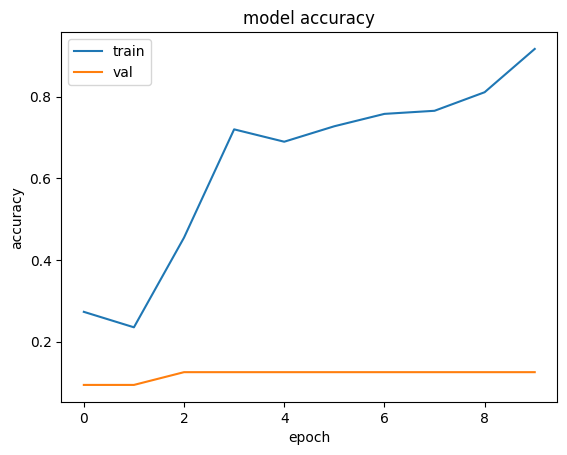

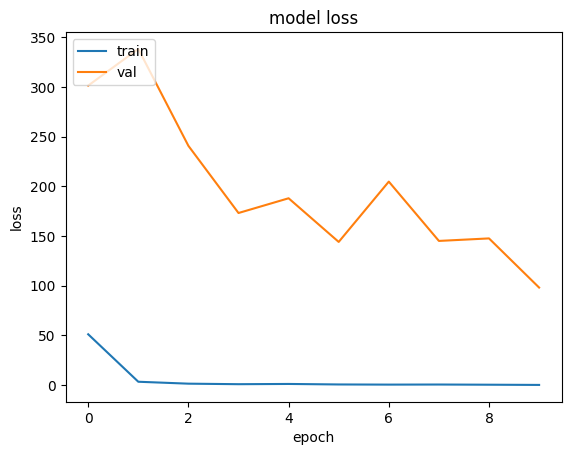

In [95]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

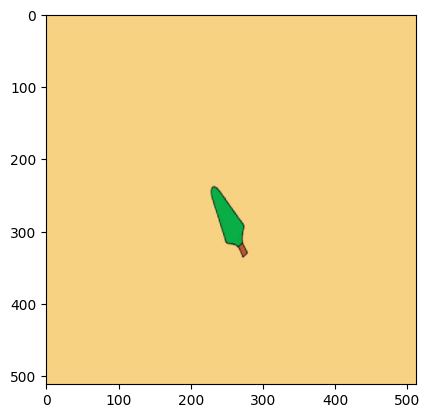

In [122]:
plt.imshow(np.array( train_gen.__getitem__(0)[0][0])) 

# 6 sınıf ile deneme 

In [6]:
num_classes =6
image_size = (224,224)
batch_size= 16
input_shape=(224, 224, 3)

In [7]:

classes ={}
df_dataset= []
for each in list_train:
    className = each.split('(')[0].replace(" ","")
    df_dataset.append([each, className])
    if className not in classes:
        classes[className] = 0
    else:
        classes[className] = classes[className] +1
    if len(classes)==num_classes and list(classes.values())[-1] ==40:
        break
        
test_classes ={}
df_dataset_test = []

for each in list_test:
    className = each.split('(')[0].replace(" ","")
    df_dataset_test.append([each, className])
  
    if className not in test_classes:
        test_classes[className] = 0    
    else:
        test_classes[className] = test_classes[className] +1
    if len(df_dataset_test)==num_classes*10 or len(test_classes)==num_classes and list(test_classes.values())[-1] ==10:
        print(len(test_classes),len(df_dataset_test))
        break  
        
random.shuffle(df_dataset)
df_dataset = pd.DataFrame(df_dataset, columns=['file_name', 'class'])
random.shuffle(df_dataset_test)
df_dataset_test = pd.DataFrame(df_dataset_test , columns=['file_name', 'class'])

6 60


In [8]:
base_model = ResNet50(include_top=False, weights='imagenet', input_shape=input_shape)

for layer in base_model.layers[:-26]:
    layer.trainable = False
for layer in base_model.layers[-26:]:
    layer.trainable = True

x = base_model.output
x = Flatten()(base_model.output)
x = Dense(100, activation='relu')(x)
predictions = Dense(num_classes, activation = 'softmax')(x)

# Define the hyperparameters to tune
#learning_rate = hp.Float('learning_rate', min_value=1e-3, max_value=1e-1, sampling='log')

optimizer = tf.keras.optimizers.Adam(learning_rate= 0.001)
# Build and compile the model
model = keras.models.Model(inputs=base_model.input, outputs=predictions)
model.compile( optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

path = "C:/Users/zouhair/Desktop/Fatma's/OneDrive - Ege Üniversitesi/Ege_Dr_D2/Deep Learning/proje1/images/Train"
test_path = "C:/Users/zouhair/Desktop/Fatma's/OneDrive - Ege Üniversitesi/Ege_Dr_D2/Deep Learning/proje1/images/Test"

datagen = ImageDataGenerator( rescale= 1./255, validation_split=0.2)

train_gen = datagen.flow_from_dataframe(dataframe=df_dataset, 
                                        directory= path,
                                        x_col= 'file_name',
                                        y_col= 'class',
                                        class_mode= "categorical",
                                        color_mode= 'rgb',
                                        subset= 'training',
                                        target_size= image_size,
                                        batch_size=batch_size )

val_gen = datagen.flow_from_dataframe(dataframe=df_dataset, 
                                        directory= path,
                                        x_col= 'file_name',
                                        y_col= 'class',
                                        class_mode= "categorical",
                                        color_mode= 'rgb',
                                        subset= 'validation',
                                        target_size= image_size,
                                        batch_size=batch_size )

test_gen = datagen.flow_from_dataframe( dataframe= df_dataset_test, 
                                        directory= test_path,
                                        x_col= 'file_name',
                                        y_col= 'class',
                                        subset= None,
                                        class_mode= "categorical",
                                        color_mode= 'rgb',
                                        target_size= image_size,
                                        batch_size= batch_size)

Found 197 validated image filenames belonging to 6 classes.
Found 49 validated image filenames belonging to 6 classes.
Found 60 validated image filenames belonging to 6 classes.


In [9]:
# Train the model
history=model.fit(train_gen, epochs=10, validation_data=val_gen)

Epoch 1/10
13/13 [==============================] - 16s 387ms/step - loss: 13.0667 - accuracy: 0.1574 - val_loss: 6.9917 - val_accuracy: 0.1633
Epoch 2/10
13/13 [==============================] - 2s 170ms/step - loss: 2.1823 - accuracy: 0.1777 - val_loss: 39.5443 - val_accuracy: 0.1837
Epoch 3/10
13/13 [==============================] - 2s 170ms/step - loss: 1.8052 - accuracy: 0.1827 - val_loss: 24.2673 - val_accuracy: 0.1837
Epoch 4/10
13/13 [==============================] - 2s 169ms/step - loss: 1.7914 - accuracy: 0.1878 - val_loss: 12.1833 - val_accuracy: 0.1633
Epoch 5/10
13/13 [==============================] - 2s 184ms/step - loss: 1.7913 - accuracy: 0.1878 - val_loss: 7.2060 - val_accuracy: 0.1633
Epoch 6/10
13/13 [==============================] - 2s 170ms/step - loss: 1.7913 - accuracy: 0.1878 - val_loss: 4.1711 - val_accuracy: 0.1633
Epoch 7/10
13/13 [==============================] - 2s 171ms/step - loss: 1.7913 - accuracy: 0.1878 - val_loss: 2.7837 - val_accuracy: 0.1633
E

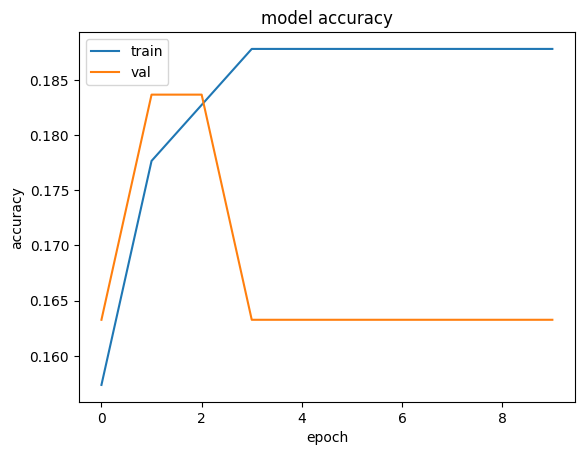

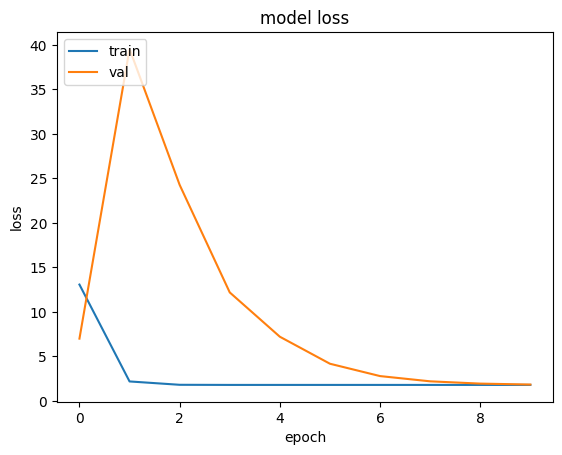

In [10]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [11]:
print("Evaluate on test data")
results = model.evaluate(test_gen, batch_size=16)
print("test loss, test acc:", results)

Evaluate on test data
4/4 [==============================] - 2s 338ms/step - loss: 1.8371 - accuracy: 0.1833
test loss, test acc: [1.8370574712753296, 0.18333333730697632]


# VGG model denemesi

In [10]:
# Set the input shape and number of classes
input_shape = (224, 224, 3)
image_size=(224, 224)
num_classes = 6
batch_size=8

In [11]:

classes ={}
df_dataset= []
for each in list_train:
    className = each.split('(')[0].replace(" ","")
    df_dataset.append([each, className])
    if className not in classes:
        classes[className] = 0
    else:
        classes[className] = classes[className] +1
    if len(classes)==num_classes and list(classes.values())[-1] ==40:
        break
        
test_classes ={}
df_dataset_test = []

for each in list_test:
    className = each.split('(')[0].replace(" ","")
    df_dataset_test.append([each, className])
  
    if className not in test_classes:
        test_classes[className] = 0    
    else:
        test_classes[className] = test_classes[className] +1
    if len(df_dataset_test)==num_classes*10 or len(test_classes)==num_classes and list(test_classes.values())[-1] ==10:
        print(len(test_classes),len(df_dataset_test))
        break  
        
random.shuffle(df_dataset)
df_dataset = pd.DataFrame(df_dataset, columns=['file_name', 'class'])
random.shuffle(df_dataset_test)
df_dataset_test = pd.DataFrame(df_dataset_test , columns=['file_name', 'class'])

6 60


In [10]:
def build_vgg_model(input_shape, num_classes):
    model = tf.keras.Sequential()
    
    # Block 1
    model.add(Conv2D(16, (3, 3), activation='relu', padding='same', input_shape=input_shape))
    model.add(Conv2D(16, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))
    
    # Block 2
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))
    
    # Block 3
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))
    
    # Block 4
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))
    
    # Block 5
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))
    
    model.add(Flatten())
    
    # Fully connected layers
    model.add(Dense(2048, activation='relu'))
    model.add(Dense(2048, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    
    return model

# Build the VGG model
model = build_vgg_model(input_shape, num_classes)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [26]:
path = "C:/Users/zouhair/Desktop/Fatma's/OneDrive - Ege Üniversitesi/Ege_Dr_D2/Deep Learning/proje1/images/Train"
test_path = "C:/Users/zouhair/Desktop/Fatma's/OneDrive - Ege Üniversitesi/Ege_Dr_D2/Deep Learning/proje1/images/Test"

datagen = ImageDataGenerator( rescale= 1./255, validation_split=0.2)

train_gen = datagen.flow_from_dataframe(dataframe=df_dataset, 
                                        directory= path,
                                        x_col= 'file_name',
                                        y_col= 'class',
                                        class_mode= "categorical",
                                        color_mode= 'rgb',
                                        subset= 'training',
                                        target_size= image_size,
                                        batch_size=batch_size )

val_gen = datagen.flow_from_dataframe(dataframe=df_dataset, 
                                        directory= path,
                                        x_col= 'file_name',
                                        y_col= 'class',
                                        class_mode= "categorical",
                                        color_mode= 'rgb',
                                        subset= 'validation',
                                        target_size= image_size,
                                        batch_size=batch_size )

test_gen = datagen.flow_from_dataframe( dataframe= df_dataset_test, 
                                        directory= test_path,
                                        x_col= 'file_name',
                                        y_col= 'class',
                                        subset= None,
                                        class_mode= "categorical",
                                        color_mode= 'rgb',
                                        target_size= image_size,
                                        batch_size= batch_size)

Found 197 validated image filenames belonging to 6 classes.
Found 49 validated image filenames belonging to 6 classes.
Found 60 validated image filenames belonging to 6 classes.


In [22]:
history=model.fit(train_gen, epochs=20, validation_data=val_gen)

Epoch 1/20
25/25 [==============================] - 4s 88ms/step - loss: 1.8356 - accuracy: 0.1320 - val_loss: 1.7927 - val_accuracy: 0.1429
Epoch 2/20
25/25 [==============================] - 1s 52ms/step - loss: 1.7940 - accuracy: 0.1421 - val_loss: 1.7948 - val_accuracy: 0.1429
Epoch 3/20
25/25 [==============================] - 1s 51ms/step - loss: 1.7921 - accuracy: 0.1523 - val_loss: 1.7946 - val_accuracy: 0.1429
Epoch 4/20
25/25 [==============================] - 1s 51ms/step - loss: 1.7918 - accuracy: 0.1371 - val_loss: 1.7953 - val_accuracy: 0.1429
Epoch 5/20
25/25 [==============================] - 1s 51ms/step - loss: 1.7920 - accuracy: 0.1523 - val_loss: 1.7966 - val_accuracy: 0.1429
Epoch 6/20
25/25 [==============================] - 1s 51ms/step - loss: 1.7920 - accuracy: 0.1574 - val_loss: 1.7965 - val_accuracy: 0.1429
Epoch 7/20
25/25 [==============================] - 1s 51ms/step - loss: 1.7917 - accuracy: 0.1371 - val_loss: 1.7974 - val_accuracy: 0.1429
Epoch 8/20
25

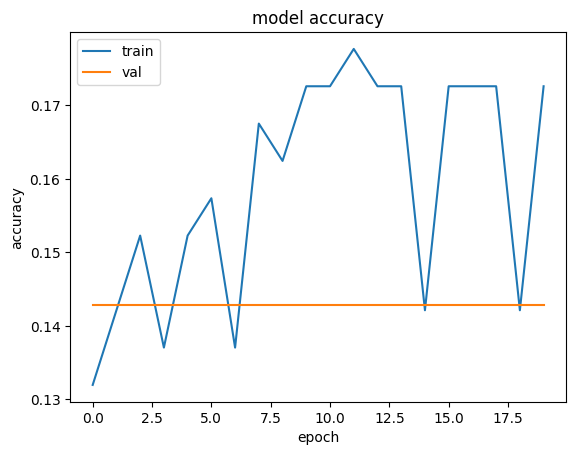

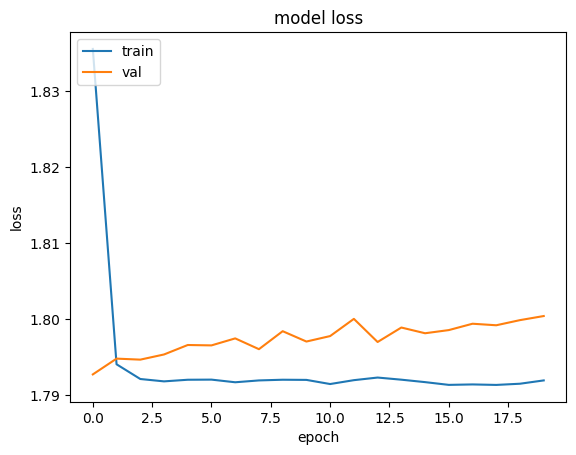

In [23]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Lets try will all of the data

In [5]:
# Set the input shape and number of classes
input_shape = (224, 224, 3)
image_size=(224, 224)
num_classes = 95
batch_size=8


classes ={}
df_dataset= []
for each in list_train:
    className = each.split('(')[0].replace(" ","")
    df_dataset.append([each, className])
    if className not in classes:
        classes[className] = 0
    else:
        classes[className] = classes[className] +1

        
test_classes ={}
df_dataset_test = []

for each in list_test:
    className = each.split('(')[0].replace(" ","")
    df_dataset_test.append([each, className])
  
    if className not in test_classes:
        test_classes[className] = 0    
    else:
        test_classes[className] = test_classes[className] +1

        
random.shuffle(df_dataset)
df_dataset = pd.DataFrame(df_dataset, columns=['file_name', 'class'])
random.shuffle(df_dataset_test)
df_dataset_test = pd.DataFrame(df_dataset_test , columns=['file_name', 'class'])

In [6]:
path = "C:/Users/zouhair/Desktop/Fatma's/OneDrive - Ege Üniversitesi/Ege_Dr_D2/Deep Learning/proje1/images/Train"
test_path = "C:/Users/zouhair/Desktop/Fatma's/OneDrive - Ege Üniversitesi/Ege_Dr_D2/Deep Learning/proje1/images/Test"

datagen = ImageDataGenerator( rescale= 1./255, validation_split=0.2)

train_gen = datagen.flow_from_dataframe(dataframe=df_dataset, 
                                        directory= path,
                                        x_col= 'file_name',
                                        y_col= 'class',
                                        class_mode= "categorical",
                                        color_mode= 'rgb',
                                        subset= 'training',
                                        target_size= image_size,
                                        batch_size=batch_size )

val_gen = datagen.flow_from_dataframe(dataframe=df_dataset, 
                                        directory= path,
                                        x_col= 'file_name',
                                        y_col= 'class',
                                        class_mode= "categorical",
                                        color_mode= 'rgb',
                                        subset= 'validation',
                                        target_size= image_size,
                                        batch_size=batch_size )

test_gen = datagen.flow_from_dataframe( dataframe= df_dataset_test, 
                                        directory= test_path,
                                        x_col= 'file_name',
                                        y_col= 'class',
                                        subset= None,
                                        class_mode= "categorical",
                                        color_mode= 'rgb',
                                        target_size= image_size,
                                        batch_size= batch_size)

Found 3114 validated image filenames belonging to 95 classes.
Found 778 validated image filenames belonging to 95 classes.
Found 1039 validated image filenames belonging to 95 classes.


In [ ]:
# modeli üstteki bölümden çalıştırdım.

In [11]:
history=model.fit(train_gen, epochs=20, validation_data=val_gen)

Epoch 1/20
390/390 [==============================] - 24s 57ms/step - loss: 4.5571 - accuracy: 0.0061 - val_loss: 4.5573 - val_accuracy: 0.0051
Epoch 2/20
390/390 [==============================] - 23s 59ms/step - loss: 4.5544 - accuracy: 0.0077 - val_loss: 4.5602 - val_accuracy: 0.0039
Epoch 3/20
390/390 [==============================] - 25s 65ms/step - loss: 4.5539 - accuracy: 0.0100 - val_loss: 4.5626 - val_accuracy: 0.0039
Epoch 4/20
390/390 [==============================] - 25s 64ms/step - loss: 4.5535 - accuracy: 0.0109 - val_loss: 4.5652 - val_accuracy: 0.0039
Epoch 5/20
390/390 [==============================] - 26s 68ms/step - loss: 4.5532 - accuracy: 0.0093 - val_loss: 4.5674 - val_accuracy: 0.0039
Epoch 6/20
390/390 [==============================] - 26s 67ms/step - loss: 4.5529 - accuracy: 0.0083 - val_loss: 4.5693 - val_accuracy: 0.0039
Epoch 7/20
390/390 [==============================] - 26s 66ms/step - loss: 4.5527 - accuracy: 0.0096 - val_loss: 4.5711 - val_accuracy:

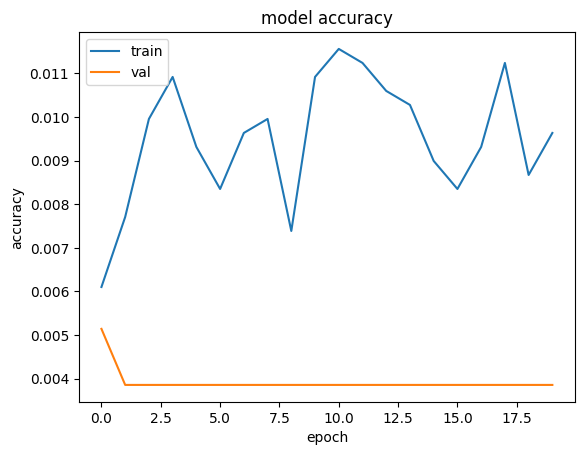

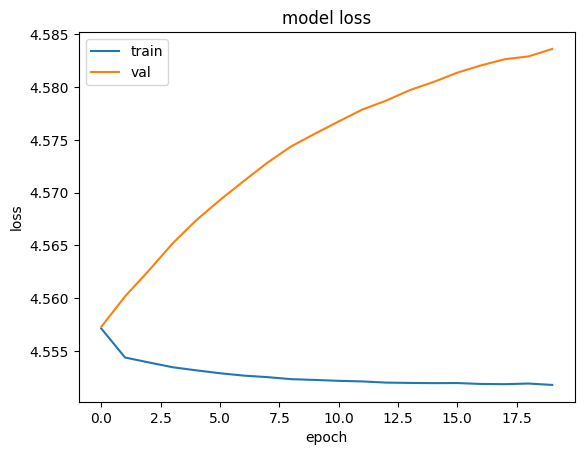

In [12]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
# Kendi CNN modelim
filters = 32
dropout = 0.3
batch_size = batch_size= 16
kernel_size = 3
input_shape = (100, 100, 3)
inputs = Input(shape=input_shape)
y = Conv2D(filters=filters,kernel_size=kernel_size,activation='relu')(inputs)
y = MaxPooling2D()(y)
y = Conv2D(filters=filters,kernel_size=kernel_size,activation='relu')(y)
y = MaxPooling2D()(y)
y = Conv2D(filters=filters, kernel_size=kernel_size, activation='relu')(y)
# convert image to vector 
y = Flatten()(y)
# dropout regularization
y = Dropout(dropout)(y)
outputs = Dense(num_classes, activation='softmax')(y)
 # model building by supplying inputs/outputs
cnn_model = Model(inputs=inputs, outputs= outputs)


In [ ]:
cnn_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
cnn_model.fit(train_gen, validation_data=test_gen, epochs=20, batch_size=batch_size)
# accuracy evaluation
score = cnn_model.evaluate(train_gen, validation_data= test_gen, batch_size=batch_size, verbose=0)
print("nTest accuracy: %.1f%%" % (100.0 * score[1]))